In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')
import torch
from torch.utils.data import DataLoader, Dataset
from torch.nn import BCEWithLogitsLoss
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, get_scheduler
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import hamming_loss
from sklearn.utils import resample
from datasets import load_dataset
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
'''Loading the balanced datasets'''
train_df = pd.read_csv('/kaggle/input/mydataset/train_balanced.csv')
val_df = pd.read_csv('/kaggle/input/mydataset/val_balanced.csv')
test_df = pd.read_csv('/kaggle/input/mydataset/test_balanced.csv')

In [3]:
'''Text Pre-processing method'''
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'[^a-z\s]', '', text)
    words = word_tokenize(text)
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return ' '.join(words)

In [4]:
label_columns = ['toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit']

In [5]:
'''Preprocessing the data'''
label_columns = [col for col in train_df.columns if col != 'text']
X = train_df[['text']]
y = train_df[label_columns]  
X_val = val_df[['text']]
y_val = val_df[label_columns] 
X_test = test_df[['text']]
y_test = test_df[label_columns] 

In [6]:
X['text'] = X['text'].apply(preprocess_text)
X_val['text'] = X_val['text'].apply(preprocess_text)
X_test['text'] = X_test['text'].apply(preprocess_text)

/tmp/ipykernel_23/183562493.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['text'] = X['text'].apply(preprocess_text)
/tmp/ipykernel_23/183562493.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val['text'] = X_val['text'].apply(preprocess_text)
/tmp/ipykernel_23/183562493.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [7]:
'''Tokenizing the data with bert tokenizer'''
tokenizer = BertTokenizer.from_pretrained("distilbert-base-uncased")
def tokenize(df):
  return tokenizer(
      df['text'].tolist(),
      padding=True,
      truncation=True,
      max_length=128,
      return_tensors="pt"
  )
X = tokenize(X)
X_val = tokenize(X_val)
X_test = tokenize(X_test)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


In [8]:
'''Adding a column consisting of list of all the labels for that comment'''
y['labels'] = y[label_columns].values.tolist()
y_val['labels'] = y_val[label_columns].values.tolist()
y_test['labels'] = y_test[label_columns].values.tolist()

In [9]:
'''Creating a custom dataset to pass to the BERT model'''
class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.encodings["input_ids"][idx],
            "attention_mask": self.encodings["attention_mask"][idx],
            "labels": self.labels[idx]
        }

train_dataset = CustomDataset(X, y["labels"].tolist())
val_dataset = CustomDataset(X_val, y_val["labels"].tolist())
test_dataset = CustomDataset(X_test, y_test["labels"].tolist())

In [10]:
# Creating data loader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
'''
Creating a BERT model and training it for 3 epochs
'''
epochs = 3
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(label_columns),  
    problem_type="multi_label_classification",
)
model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)
num_training_steps = len(train_loader) * epochs
scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)
criterion = torch.nn.BCEWithLogitsLoss()
t_loss, v_loss = [], []
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = criterion(logits, labels)
        train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {avg_train_loss:.4f}")
    t_loss.append(avg_train_loss)
    model.eval()
    val_loss = 0
    preds, true_labels = [], []
    
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = criterion(logits, labels)
            val_loss += loss.item()
            preds.append(torch.sigmoid(logits).cpu().numpy())
            true_labels.append(labels.cpu().numpy())
    
    avg_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {avg_val_loss:.4f}")
    v_loss.append(avg_val_loss)
    preds = np.vstack(preds)
    true_labels = np.vstack(true_labels)
    preds_binary = (preds > 0.3).astype(int)
    accuracy = accuracy_score(true_labels, preds_binary)
    f1 = f1_score(true_labels, preds_binary, average="weighted")
    
    print(f"Validation Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")

model.save_pretrained("./bert_multilabel_model")

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3, Training Loss: 0.3830
Validation Loss: 0.3481
Validation Accuracy: 0.3482, F1 Score: 0.6410
Epoch 2/3, Training Loss: 0.3217
Validation Loss: 0.3280
Validation Accuracy: 0.4320, F1 Score: 0.6648
Epoch 3/3, Training Loss: 0.2926
Validation Loss: 0.3333
Validation Accuracy: 0.4076, F1 Score: 0.6667


In [13]:
'''
Checking the test metrics
'''
preds, true_labels = [], []
with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds.append(torch.sigmoid(logits).cpu().numpy())
            true_labels.append(labels.cpu().numpy())

In [21]:
preds = np.vstack(preds)
true_labels = np.vstack(true_labels)
preds_binary = (preds > 0.3).astype(int)
accuracy = accuracy_score(true_labels, preds_binary)
f1 = f1_score(true_labels, preds_binary, average="weighted")
prec = precision_score(true_labels, preds_binary, average="macro")
rec = recall_score(true_labels, preds_binary, average="macro")
print("Test Accuracy", accuracy)
print("Precision", prec)
print("Recall", rec)
print("F1", f1)

Test Accuracy 0.4079246139872843
Precision 0.6358316767715838
Recall 0.7059917229552359
F1 0.6685069649419104


In [15]:
# Calculating the hamming loss
hamming_loss_value = hamming_loss(true_labels, preds_binary)
print(f"Hamming Loss: {hamming_loss_value:.4f}")

Hamming Loss: 0.1526


In [16]:
y_pred = preds_binary
y_true = true_labels
y_pred = pd.DataFrame(y_pred, columns=label_columns)
y_true = pd.DataFrame(y_true, columns=label_columns)

In [20]:
# Getting the metrics for each label separately
label_metrics = {}

for label in y_true.columns:
    precision = precision_score(y_true[label], y_pred[label], zero_division=0)
    recall = recall_score(y_true[label], y_pred[label])
    f1 = f1_score(y_true[label], y_pred[label])
    accuracy = accuracy_score(y_true[label], y_pred[label])

    label_metrics[label] = {
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'accuracy': accuracy
    }

for label, metrics in label_metrics.items():
    print(f"Metrics for {label}:")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1_score']:.4f}")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print()

Metrics for toxicity:
Precision: 0.5757
Recall: 0.9188
F1 Score: 0.7079
Accuracy: 0.8090

Metrics for severe_toxicity:
Precision: 0.4233
Recall: 0.4909
F1 Score: 0.4546
Accuracy: 0.7415

Metrics for obscene:
Precision: 0.7303
Recall: 0.7263
F1 Score: 0.7283
Accuracy: 0.8773

Metrics for threat:
Precision: 0.5626
Recall: 0.5878
F1 Score: 0.5749
Accuracy: 0.8394

Metrics for insult:
Precision: 0.7253
Recall: 0.8940
F1 Score: 0.8009
Accuracy: 0.8862

Metrics for identity_attack:
Precision: 0.7118
Recall: 0.7301
F1 Score: 0.7208
Accuracy: 0.8927

Metrics for sexual_explicit:
Precision: 0.7218
Recall: 0.5939
F1 Score: 0.6516
Accuracy: 0.8860



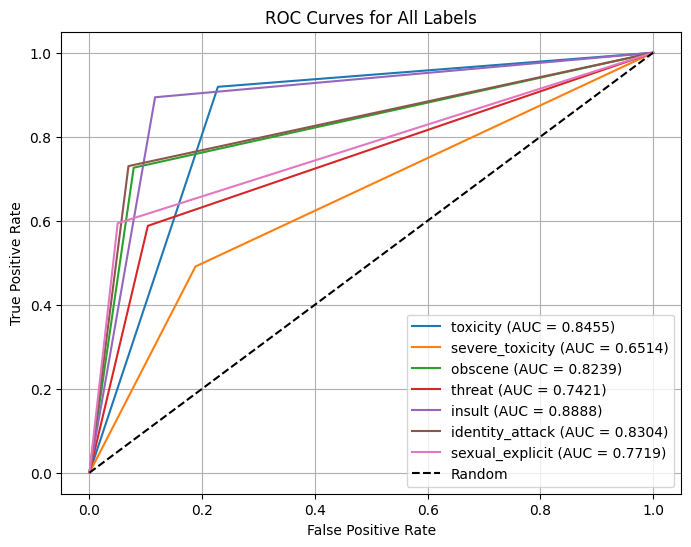

In [29]:
# Plotting ROC-AUC for all labels
def plot_roc_auc(y_true, y_pred_prob, label_columns):
    plt.figure(figsize=(8, 6))  
    for i, label in enumerate(label_columns):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_prob[:, i])
        auc = roc_auc_score(y_true[:, i], y_pred_prob[:, i])
        plt.plot(fpr, tpr, label=f'{label} (AUC = {auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for All Labels')
    plt.legend(loc='lower right')
    plt.grid()

    plt.savefig('./auc_roc.png')
    plt.show()  



plot_roc_auc(true_labels, preds_binary, label_columns)


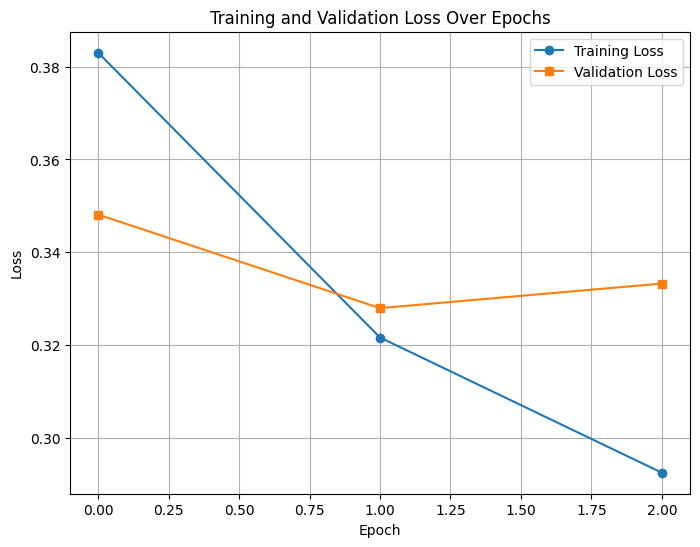

In [30]:
# Plotting training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(t_loss, label='Training Loss', marker='o')
plt.plot(v_loss, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.savefig('loss_plot.png') 
plt.show() 